In [7]:
import numpy as np
import pandas as pd
import scipy
import scanpy as sc
import scipy.sparse as sp
import anndata as ad
import matplotlib.pyplot as pl
import anndata
import random
import scanpy.plotting
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri

import sklearn as sk
import pandas as pd
import numpy as np
import pathlib as pl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import zero_one_loss

import os
import sys
# os.chdir("D:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\vignettes")
os.chdir("C:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\vignettes")
import gc

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

custom_colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
palette = sns.set_palette(sns.color_palette(custom_colors))
FP_CRC_ORI = os.path.join("CRC.csv")
FP_CRC = os.path.join("unified_data.csv")
FP_CRC_SEP = os.path.join("unified_sepa_data.csv")
FP_CRCMAT = os.path.join("crc_mat.csv")

In [8]:
crc = pd.read_csv(FP_CRC)
crc_sep = pd.read_csv(FP_CRC_SEP)
crc_ori = pd.read_csv(FP_CRC_ORI)

In [10]:
crc_ori

,Unnamed: 0,study_name,study_condition,subject_id,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Faecalibacterium.s__Faecalibacterium_prausnitzii,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.s__Streptococcus_salivarius,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Anaerostipes.s__Anaerostipes_hadrus,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_stercoris,k__Bacteria.p__Actinobacteria.c__Coriobacteriia.o__Coriobacteriales.f__Coriobacteriaceae.g__Collinsella.s__Collinsella_aerofaciens,k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Bifidobacteriales.f__Bifidobacteriaceae.g__Bifidobacterium.s__Bifidobacterium_longum,...,k__Bacteria.p__Proteobacteria.c__Epsilonproteobacteria.o__Campylobacterales.f__Campylobacteraceae.g__Campylobacter.s__Campylobacter_rectus,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiaceae.g__Clostridium.s__Clostridium_sp_CAG_678,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Leuconostocaceae.g__Leuconostoc.s__Leuconostoc_citreum,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.s__Streptococcus_sp_oral_taxon_058,k__Archaea.p__Euryarchaeota.c__Thermoplasmata.o__Methanomassiliicoccales.f__Methanomassiliicoccaceae.g__Methanomassiliicoccus.s__Candidatus_Methanomassiliicoccus_intestinalis,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.s__Streptococcus_sp_HMSC067H01,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Lactococcus.s__Lactococcus_piscium,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellales.f__Peptoniphilaceae.g__Anaerococcus.s__Anaerococcus_lactolyticus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pseudomonadales.f__Pseudomonadaceae.g__Pseudomonas.s__Pseudomonas_lundensis,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Lactobacillaceae.g__Lactobacillus.s__Lactobacillus_algidus
0,SID31004,FengQ_2015,CRC,SID31004,13.58862,11.00755,8.26264,5.21961,4.58481,3.91280,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
1,SID31009,FengQ_2015,control,SID31009,5.18307,0.13897,7.55176,0.00000,3.68522,2.36947,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2,SID31021,FengQ_2015,control,SID31021,6.09213,0.17498,8.26219,0.01189,2.67519,4.17384,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
3,SID31071,FengQ_2015,control,SID31071,12.96581,0.26242,3.07124,0.06529,7.94793,6.54146,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
4,SID31112,FengQ_2015,control,SID31112,0.42582,0.27282,4.99914,0.00000,19.62228,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,CRC_MR_SBJ80H_17,ThomasAM_2018b,control,SBJ80H,5.33588,0.17927,3.03819,1.30088,1.05425,1.28187,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
331,CRC_MR_SBJ81H_17,ThomasAM_2018b,control,SBJ81H,6.71809,0.10334,0.03505,0.00000,3.40447,7.33103,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
332,CRC_MR_SBJ82H_17,ThomasAM_2018b,control,SBJ82H,10.75468,0.09453,2.68905,0.00000,0.00000,5.05345,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
333,CRC_MR_SBJ83H_17,ThomasAM_2018b,control,SBJ83H,13.30765,2.46513,0.25763,0.09922,1.88936,0.17597,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0264


In [11]:
crc.T

,0,1,2,3,4,5,6,7,8,9,...,925,926,927,928,929,930,931,932,933,934
taxon,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,k__Bacteria|p__Actinobacteria|c__Coriobacterii...,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,...,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacill...,k__Bacteria|p__Proteobacteria|c__Epsilonproteo...,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,k__Bacteria|p__Proteobacteria|c__Gammaproteoba...,k__Bacteria|p__Actinobacteria|c__Actinobacteri...
SID31004,5557520.0,4501905.0,3379283.0,2134734.0,1875111.0,1600270.0,1543442.0,1537307.0,1522662.0,1487988.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SID31009,3426422.0,91870.0,4992315.0,0.0,2436224.0,1566408.0,0.0,5130.0,2955614.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SID31021,3703353.0,106369.0,5022513.0,7228.0,1626225.0,2537241.0,0.0,342887.0,776326.0,1438210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SID31030,1407572.0,78931.0,540874.0,300730.0,1104594.0,491720.0,0.0,545275.0,724756.0,767280.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCIS95409808ST.4.0,1021983.0,186876.0,643569.0,32664.0,1199899.0,793182.0,0.0,328772.0,1637341.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7950.0
CCIS96387239ST.4.0,2306131.0,22790.0,21378.0,327276.0,781411.0,397046.0,0.0,633642.0,165012.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCIS98482370ST.3.0,1795756.0,6503.0,701544.0,3724477.0,20806.0,12635.0,0.0,5940563.0,125387.0,1484273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCIS98512455ST.4.0,1615860.0,191933.0,328142.0,2138003.0,90401.0,0.0,0.0,1069434.0,3311663.0,1882126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
crc_sep

,kingdom,phylum,class,order,family,genus,species,SID31004,SID31009,SID31021,...,CCIS93040568ST.20.0,CCIS94417875ST.3.0,CCIS94496512ST.4.0,CCIS94603952ST.4.0,CCIS95097901ST.4.0,CCIS95409808ST.4.0,CCIS96387239ST.4.0,CCIS98482370ST.3.0,CCIS98512455ST.4.0,CCIS98832363ST.4.0
0,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Faecalibacterium,s__Faecalibacterium_prausnitzii,5557520.0,3426422.0,3703353.0,...,503259.0,2248984.0,1559275.0,6611627.0,1023376.0,1021983.0,2306131.0,1795756.0,1615860.0,5390451.0
1,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Streptococcaceae,g__Streptococcus,s__Streptococcus_salivarius,4501905.0,91870.0,106369.0,...,5419.0,47366.0,98496.0,74363.0,190128.0,186876.0,22790.0,6503.0,191933.0,4990.0
2,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Anaerostipes,s__Anaerostipes_hadrus,3379283.0,4992315.0,5022513.0,...,0.0,1550855.0,1274373.0,1027296.0,2574254.0,643569.0,21378.0,701544.0,328142.0,1401648.0
3,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_stercoris,2134734.0,0.0,7228.0,...,0.0,182815.0,68009.0,0.0,8416.0,32664.0,327276.0,3724477.0,2138003.0,0.0
4,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__Collinsella,s__Collinsella_aerofaciens,1875111.0,2436224.0,1626225.0,...,0.0,177630.0,1759700.0,1892.0,2494268.0,1199899.0,781411.0,20806.0,90401.0,2334831.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Corynebacteriales,f__Corynebacteriaceae,g__Corynebacterium,s__Corynebacterium_pseudodiphtheriticum,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
931,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__Lactobacillus_crustorum,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
932,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,g__Lactobacillus,s__Lactobacillus_farciminis,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933,k__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Klebsiella,s__Klebsiella_quasivariicola,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,3584.0,0.0,0.0,0.0,0.0,0.0


In [6]:
study_names = np.unique(crc.study_name)

AttributeError: 'DataFrame' object has no attribute 'study_name'

In [67]:
study_names

array(['FengQ_2015', 'GuptaA_2019', 'HanniganGD_2017', 'ThomasAM_2018a',
       'ThomasAM_2018b'], dtype=object)

In [71]:
# compute not-all-zero species for each study 
valid_species = dict()
for name in study_names:
    X_study = crc[crc['study_name']==name]
    species = X_study.columns[(X_study != 0).any()]
    valid_species[name] = species

In [72]:
valid_species

{'FengQ_2015': Index(['Unnamed: 0', 'study_name', 'study_condition', 'subject_id',
        'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Faecalibacterium.s__Faecalibacterium_prausnitzii',
        'k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.s__Streptococcus_salivarius',
        'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Anaerostipes.s__Anaerostipes_hadrus',
        'k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_stercoris',
        'k__Bacteria.p__Actinobacteria.c__Coriobacteriia.o__Coriobacteriales.f__Coriobacteriaceae.g__Collinsella.s__Collinsella_aerofaciens',
        'k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Bifidobacteriales.f__Bifidobacteriaceae.g__Bifidobacterium.s__Bifidobacterium_longum',
        ...
        'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__L

In [77]:
for key in valid_species:
    print(f'{key} has {len(valid_species[key])}')

FengQ_2015 has 582
GuptaA_2019 has 312
HanniganGD_2017 has 267
ThomasAM_2018a has 439
ThomasAM_2018b has 507


In [74]:
valid_species.keys

<function dict.keys>

In [45]:
X = crc.iloc[:, 4:].values
y = crc.iloc[:, 2] == "CRC"

In [46]:
X.shape

(335, 754)

In [82]:
y

0       True
1      False
2      False
3      False
4      False
       ...  
330    False
331    False
332    False
333    False
334    False
Name: study_condition, Length: 335, dtype: bool

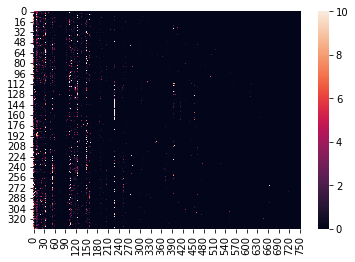

In [55]:
sns.heatmap(X, vmax=10)

# Display the heatmap
plt.show()

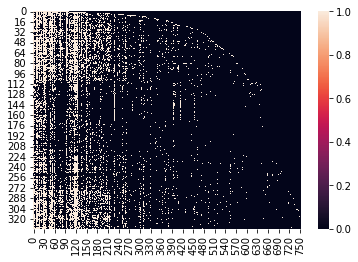

In [44]:
sns.heatmap(X != 0)
plt.show()

In [63]:
np.mean(X>0)

0.11326259946949602

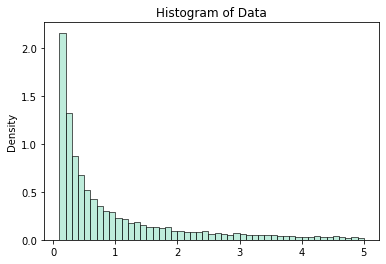

In [81]:
sns.histplot(data=X.reshape(-1), binwidth=0.1, binrange=[0.1, 5], stat="density")
plt.title("Histogram of Data")
# plt.xlabel("X-axis Label")
# plt.ylabel("Y-axis Label")
plt.show()

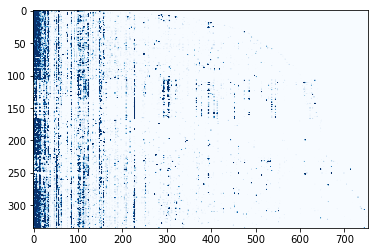

In [50]:
plt.imshow(X, cmap='Blues', aspect='auto', vmin=0, vmax=1)

In [89]:
study_test = [study_names[-1]]
study_train = study_names[:-1]

In [95]:
data_train = crc[crc['study_name'].isin(study_train)]
data_test = crc[crc['study_name'].isin(study_test)]

X_train = data_train.iloc[:, 4:].values
X_test = data_test.iloc[:, 4:].values
y_train = data_train.iloc[:, 2] == "CRC"
y_test = data_test.iloc[:, 2] == "CRC"

In [96]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(275, 754)
(60, 754)
(275,)
(60,)


In [135]:
# Run PCA
p = 100

X_train_sd = StandardScaler().fit_transform(X_train)
X_train_pca = PCA(n_components=p)
X_train_pca.fit(X_train_sd)
X_train = X_train_pca.transform(X_train_sd)

In [141]:
# Logstic
model = LogisticRegression()
model.fit(X_train, y_train)

X_test_sd = StandardScaler().fit_transform(X_test)
X_test = X_train_pca.transform(X_test_sd)
y_pred = model.predict(X_test)

loss = zero_one_loss(y_pred, y_test)

print("0-1 loss of the test set:", loss)

0-1 loss of the test set: 0.4833333333333333


In [127]:
X_test.shape

(60, 100)

In [132]:
X_test_sd.shape

(60, 100)

In [ ]:
# # Load the RDA file
# robjects.r['load'](FP_CRC)

# # Convert the R data frame to a Pandas data frame
# r_dataframe = robjects.r['se']
# pandas_dataframe = pd.DataFrame(dict(zip(r_dataframe.names, list(r_dataframe))))

# # Use the Pandas data frame in Python
# print(pandas_dataframe.head())